In [11]:
import json
import pickle
from rdkit import Chem
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
import sascorer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
with open("../test_set_sim_search.pkl", "rb") as f:
    test_set_smiles_to_train_set_diff_vector_and_distance = pickle.load(f)
test_set_smiles_to_train_set_diff_vector_and_distance

{'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_0': {'min_euclidean_dist': {'smile': 'CNC(=O)Oc1ccc2c(c1)C1(C)CCN(C)C1N2C_4356',
   'dist': 7.569423},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_51119',
   'dist': -4.50906e-06},
  'max_cosine_sim': {'smile': 'COc1ccccc1N1CCN(CCCCN2C(=O)c3ccccc3C2=O)CC1_58004',
   'dist': 2.869751e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_1': {'min_euclidean_dist': {'smile': 'CN(CCOc1ccc(CC2SC(=O)NC2=O)cc1)c1ccccn1_10031',
   'dist': 6.8265467},
  'min_cosine_sim': {'smile': 'CC(=O)C(C#N)C(=O)Nc1cc(Br)ccc1Br_3570',
   'dist': -1.1796407e-06},
  'max_cosine_sim': {'smile': 'OC1(c2ccc(Cl)c(C(F)(F)F)c2)CCN(CCCC(c2ccc(F)cc2)c2ccc(F)cc2)CC1_21393',
   'dist': 1.384695e-06}},
 'COc1ccccc1N1CCN(CC(O)COc2cccc3ccccc23)CC1_2': {'min_euclidean_dist': {'smile': 'CC1(C)SC2C(N=CN3CCCCCC3)C(=O)N2C1C(=O)O_37665',
   'dist': 7.199553},
  'min_cosine_sim': {'smile': 'CCN(CC)CCNC(=O)c1c(C)[nH]c(C=C2C(=O)Nc3ccc(Cl)cc32)c1C_511

In [6]:
tmp3_df = pd.read_csv("../test_set_similarity_search_structural_similarities.csv")
tmp3_df.head()

,m_fp_tanimoto_sim,maccs_fp_tanimoto_sim,fraggle_sims,dist_type
0,0.098214,0.472222,0.627219,euclidean_dist
1,0.092437,0.567568,0.494118,euclidean_dist
2,0.110092,0.460526,0.237668,euclidean_dist
3,0.180952,0.578313,0.796875,euclidean_dist
4,0.113402,0.654545,0.685484,euclidean_dist


Text(0.5, 1.0, 'Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

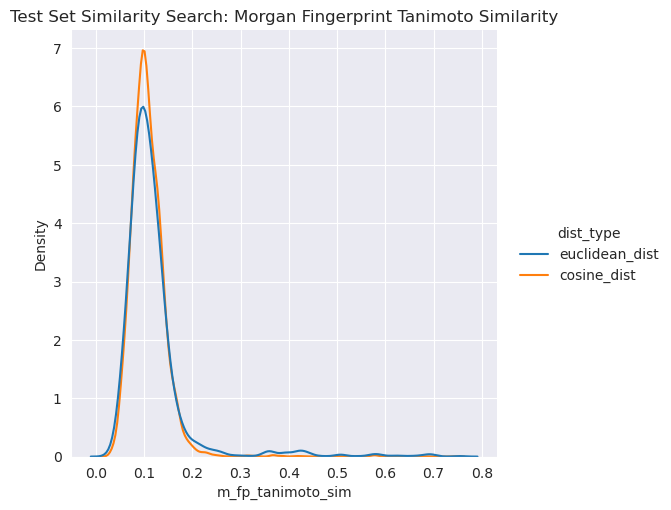

In [12]:
sns.set_style('darkgrid')
sns.displot(tmp3_df,x = 'm_fp_tanimoto_sim',  hue="dist_type", kind = 'kde')

plt.title('Test Set Similarity Search: Morgan Fingerprint Tanimoto Similarity')

In [17]:
with open("cond_generation_res/ldm_uncon_vae_test_set_smile_to_max_sim_generated_molecule.pkl", "rb") as f:
    ldm_vae_data = pickle.load(f)

In [18]:
ldm_vae_data

{}